# Modelling of Physical Systems lab 5 - Stanisław Borowy

## Introduction

Below is a solution to advection problem that improves upon upwind scheme by applying a correction to its results by applying it backwards with pseudo, anti-diffusive velocity. This correction may be applited arbitrary number of times, hopefully yielding better and better results.

## Code from lab for solving MPData

In [1]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [2]:
class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i): 
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i): 
        return slice(i.start - self.sub, i.stop - self.sub)

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

def upwind(psi, i, C):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf]) 
    )

In [3]:
def solve_upwind(*, nt: int, C: float, psi: np.ndarray):
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
    return psi

def psi_0(x: np.ndarray, x0: float = 0, a: float = 1, sigma: float = 20):
    return a * np.exp(-(x-x0)**2 / 2 / sigma**2)

def plot(x, **kwargs):
    for label, data in kwargs.items():
        pyplot.step(x, data, label=label, where='mid')
    pyplot.legend()
    pyplot.grid()
    show_plot()

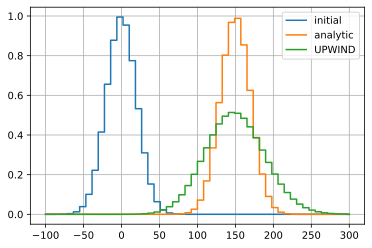

In [4]:
u = 0.25
t_max = 600

nx = 50
nt = 200
dt = t_max / nt
x, dx = np.linspace(-100, 300, nx, retstep=True)

plot(
    x=x,
    initial=psi_0(x),
    analytic=psi_0(x - u * t_max),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x))
)

In [5]:
def corrective_C(C, i, psi):
    return (np.abs(C[i - hlf]) - np.power(C[i - hlf], 2)) * (psi[i] - psi[i - one])/(psi[i] + psi[i - one])

def solve_mpdata(*, nt: int, C: float, psi: np.ndarray):
    i_ext = slice(1, len(psi))
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
        upwind(psi, slice(1, len(C)), corrective_C(C, i_ext, psi))
    
    return psi

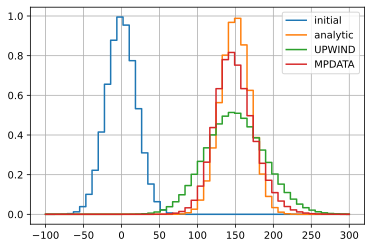

In [6]:
plot(
    x=x, 
    initial=psi_0(x),
    analytic=psi_0(x-u*t_max),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x)),
    MPDATA=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x))
)

## Iterative MPData

In [7]:
def solve_mpdata_iterative(*, nt: int, C: float, psi: np.ndarray, iterations: int):
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
        C_prim = C
        for _ in range(iterations):
            C_prim = corrective_C(C_prim, slice(1, len(psi)), psi)
            upwind(psi, slice(1, len(C)), C_prim)
    return psi

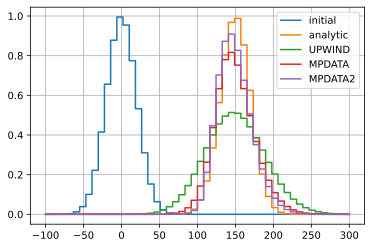

In [8]:
plot(
    x=x, 
    initial=psi_0(x),
    analytic=psi_0(x-u*t_max),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x)),
    MPDATA=solve_mpdata_iterative(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), iterations=1),
    MPDATA2=solve_mpdata_iterative(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), iterations=2)
)

In [9]:
def rmse(y_pred, y_true):
    return np.sqrt(np.sum((y_pred - y_true) ** 2) / len(y_true))

def psi_analytic(x, u, t):
    return psi_0(x - u * t)

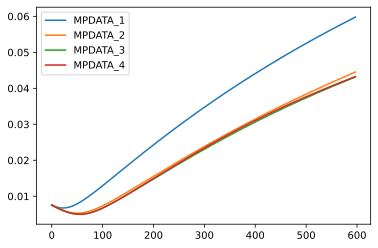

In [10]:
def compare(iterations: int):
    psi_current = psi_0(x)
    rmses = []
    for ti in range(nt):
        t = ti * dt
        psi_a = psi_analytic(x, u, t)
        psi_current = solve_mpdata_iterative(nt=1, C=np.full(nx - 1, u * dt / dx), psi=psi_current, iterations=iterations)
        diff = rmse(psi_a, psi_current)
        rmses.append(diff)
    return rmses

times = [ti * dt for ti in range(nt)]

for i in range(1, 5):
    rmses = compare(i)
    pyplot.plot(times, rmses, label=f"MPDATA_{i}")
    pyplot.legend()
show_plot("comparisons.pdf")